In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
os.environ["CUDA_VISIBLE_DEVICES"]="0" 

In [2]:
import ktrain
from ktrain import graph as gr

Using TensorFlow backend.


using Keras version: 2.2.4


# Node Classification in Graphs


In this notebook, we will use *ktrain* to perform node classificaiton on the PubMed Diabetes citation graph.  In the PubMed graph, each node represents a paper pertaining to one of three topics:  *Diabetes Mellitus - Experimental*, *Diabetes Mellitus - Type 1*, and *Diabetes Mellitus - Type 2*.  Links represent citations between papers.  The attributes or features assigned to each node are in the form of a vector of words in each paper and their corresponding TF-IDF scores.  The dataset is available [here](https://linqs-data.soe.ucsc.edu/public/Pubmed-Diabetes.tgz).

*ktrain* expects two files for node classification problems.  The first is comma or tab delimited file listing the edges in the graph, where each row contains the node IDs forming the edge.  The second is a comma or tab delimted file listing the features or attributes associated with each node in the graph.  The first column in this file is the User ID and the last column should be string representing the target or label of the node.  All other nodes should be numerical features assumed to be standardized appropriately and non-null.  

We must prepare the raw data to conform to the above before we begin.

### Preparing the Data
The code below will create two files that can be processed directly by *ktrain*:
- `/tmp/pubmed-nodes.tab`
- `/tmp/pubmed-edges.tab`

In [3]:
# set this to the location of the downloaded Pubmed-Diabetes data
DATADIR = 'data/pubmed/Pubmed-Diabetes/data'

In [4]:
import os.path
import pandas as pd
import itertools

# process links
edgelist = pd.read_csv(os.path.join(DATADIR, 'Pubmed-Diabetes.DIRECTED.cites.tab'), 
                      skiprows=2, header=None,delimiter='\t')
edgelist.drop(columns=[0,2], inplace=True)
edgelist.columns = ['source', 'target']
edgelist['source'] = edgelist['source'].map(lambda x: x.lstrip('paper:')) 
edgelist['target'] = edgelist['target'].map(lambda x: x.lstrip('paper:'))
edgelist.head()
edgelist.to_csv('/tmp/pubmed-edges.tab', sep='\t', header=None, index=False )

# process nodes and their attributes
nodes_as_dict = []
with open(os.path.join(os.path.expanduser(DATADIR), "Pubmed-Diabetes.NODE.paper.tab")) as fp:
    for line in itertools.islice(fp, 2, None):
        line_res = line.split("\t")
        pid = line_res[0]
        feat_name = ['pid'] + [l.split("=")[0] for l in line_res[1:]][:-1] # delete summary
        feat_value = [l.split("=")[1] for l in line_res[1:]][:-1] # delete summary
        feat_value = [pid] + [ float(x) for x in feat_value ] # change to numeric from str
        row = dict(zip(feat_name, feat_value))
        nodes_as_dict.append(row)
colnames = set()
for row in nodes_as_dict:
    colnames.update(list(row.keys()))
colnames = list(colnames)
colnames.sort()
colnames.remove('label')
colnames.append('label')
target_dict = {1:'Diabetes_Mellitus-Experimental', 2: 'Diabetes_Mellitus-Type_1', 3:'Diabetes_Mellitus-Type_2', }
with open('/tmp/pubmed-nodes.tab', 'w') as fp:
    #fp.write("\t".join(colnames)+'\n')
    for row in nodes_as_dict:
        feats = []
        for col in colnames:
            feats.append(row.get(col, 0.0))
        feats = [str(feat) for feat in feats]
        feats[-1] = round(float(feats[-1]))
        feats[-1] = target_dict[feats[-1]]
        fp.write("\t".join(feats) + '\n')

### STEP 1: Load and Preprocess Data

We will hold out 20% of the nodes as test nodes by setting `holdout_pct=0.2`.  Since we specified `holdout_for_inductive=True`, these heldout nodes are removed from the graph in order to later simulate making predicitions on new nodes added to the graph later (or *inductive inference*). If `holdout_for_inductive=False`, the features (not labels) of these nodes are accessible to the model during training.  Of the remaining nodes, 5% will be used for training and the remaining nodes will be used for validation (or *transductive inference*).  More information on transductive and inductive inference and the return values `df_holdout` and `df_complete` are provided below.

Note that if there are any unlabeled nodes in the graph, these will be automatically used as heldout nodes for which predictions can be made once the model is trained.  See the [twitter example notebook](https://github.com/amaiya/ktrain/blob/master/examples/graphs/hateful_twitter_users-GraphSAGE.ipynb) for an example of this.

In [5]:
(train_data, val_data, preproc, 
 df_holdout, G_complete)        = gr.graph_nodes_from_csv('/tmp/pubmed-nodes.tab',
                                           '/tmp/pubmed-edges.tab',
                                           sample_size=10, holdout_pct=0.2, holdout_for_inductive=True,
                                           train_pct=0.05, sep='\t')

Largest subgraph statistics: 19717 nodes, 44327 edges
Size of training graph: 15774 nodes
Training nodes: 788
Validation nodes: 14986
Nodes treated as unlabeled for testing/inference: 3943
Size of graph with added holdout nodes: 19717
Holdout node features are not visible during training (inductive_inference)



The `preproc` object includes a reference to the training graph and a dataframe showing the features and target for each node in the graph (both training and validation nodes).

In [6]:
preproc.df.target.value_counts()

Diabetes_Mellitus-Type_1          6255
Diabetes_Mellitus-Type_2          6242
Diabetes_Mellitus-Experimental    3277
Name: target, dtype: int64

### STEP 2: Build a Model and Wrap in Learner Object

In [7]:
gr.print_node_classifiers()

graphsage: GraphSAGE:  http://arxiv.org/pdf/1607.01759.pdf


In [8]:
learner = ktrain.get_learner(model=gr.graph_node_classifier('graphsage', train_data), 
                             train_data=train_data, 
                             val_data=val_data, 
                             batch_size=64)

Is Multi-Label? False
done


### STEP 3:  Estimate LR 
Given the small number of batches per epoch, a larger number of epochs is required to estimate the learning rate. We will cap it at 100 here.

In [9]:
learner.lr_find(max_epochs=100)

simulating training for different learning rates... this may take a few moments...
Epoch 1/100
12/12 [==============================] - 1s 85ms/step - loss: 1.1021 - acc: 0.3638
Epoch 2/100
12/12 [==============================] - 0s 30ms/step - loss: 1.0971 - acc: 0.3743
Epoch 3/100
12/12 [==============================] - 0s 34ms/step - loss: 1.1027 - acc: 0.3324
Epoch 4/100
12/12 [==============================] - 0s 30ms/step - loss: 1.1024 - acc: 0.3402
Epoch 5/100
12/12 [==============================] - 0s 33ms/step - loss: 1.1034 - acc: 0.3294
Epoch 6/100
12/12 [==============================] - 0s 32ms/step - loss: 1.0960 - acc: 0.3763
Epoch 7/100
12/12 [==============================] - 0s 33ms/step - loss: 1.0965 - acc: 0.3534
Epoch 8/100
12/12 [==============================] - 0s 33ms/step - loss: 1.1091 - acc: 0.3430
Epoch 9/100
12/12 [==============================] - 0s 33ms/step - loss: 1.1116 - acc: 0.3320
Epoch 10/100
12/12 [==============================] - 0s 31ms/

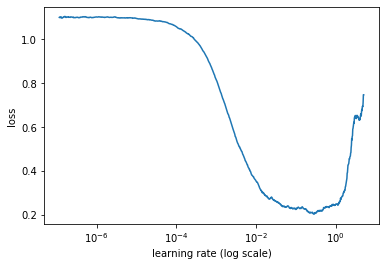

In [10]:
learner.lr_plot()

### STEP 4: Train the Model
We will train the model using `autofit`, which uses a triangular learning rate policy.  The training will automatically stop when the validation loss no longer improves.

In [9]:
learner.autofit(0.01)

early_stopping automatically enabled at patience=5
reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 0.01...
Epoch 1/1024
13/13 [==============================] - 6s 484ms/step - loss: 1.0057 - acc: 0.4807 - val_loss: 0.8324 - val_acc: 0.6990
Epoch 2/1024
13/13 [==============================] - 6s 425ms/step - loss: 0.8001 - acc: 0.7077 - val_loss: 0.6512 - val_acc: 0.7795
Epoch 3/1024
13/13 [==============================] - 6s 438ms/step - loss: 0.6322 - acc: 0.8045 - val_loss: 0.5574 - val_acc: 0.7875
Epoch 4/1024
13/13 [==============================] - 6s 430ms/step - loss: 0.5251 - acc: 0.8237 - val_loss: 0.5077 - val_acc: 0.8106
Epoch 5/1024
13/13 [==============================] - 6s 476ms/step - loss: 0.4407 - acc: 0.8600 - val_loss: 0.5061 - val_acc: 0.8086
Epoch 6/1024
13/13 [==============================] - 6s 454ms/step - loss: 0.3857 - acc: 0.8697 - val_loss: 0.5033 - val_acc: 0.8046
Epoch 7/1024


## Evaluate

#### Validate

In [10]:
learner.validate(class_names=preproc.get_classes())

                                precision    recall  f1-score   support

Diabetes_Mellitus-Experimental       0.76      0.82      0.79      3113
      Diabetes_Mellitus-Type_1       0.84      0.81      0.82      5943
      Diabetes_Mellitus-Type_2       0.85      0.84      0.85      5930

                      accuracy                           0.83     14986
                     macro avg       0.82      0.82      0.82     14986
                  weighted avg       0.83      0.83      0.83     14986



array([[2553,  362,  198],
       [ 440, 4815,  688],
       [ 359,  572, 4999]])

#### Create a Predictor Object

In [11]:
p = ktrain.get_predictor(learner.model, preproc)

#### Transductive Inference:  Making Predictions for Unlabeled Nodes in Original Training Graph
In transductive inference, we make predictions for unlabeled nodes whose features are visible during training. Making predictions on validation nodes in the training graph is transductive inference.

Let's see how well our prediction is for the first validation example.

In [12]:
p.predict_transductive(val_data.ids[0:1], return_proba=True)

array([[0.04122107, 0.9422023 , 0.0165766 ]], dtype=float32)

In [13]:
val_data[0][1][0]

array([0., 1., 0.])

Let's make predictions for all validation nodes and visually compare some of them with ground truth.

In [14]:
y_pred = p.predict_transductive(val_data.ids, return_proba=False)

In [15]:
y_true = preproc.df[preproc.df.index.isin(val_data.ids)]['target'].values

In [16]:
import pandas as pd
pd.DataFrame(zip(y_true, y_pred), columns=['Ground Truth', 'Predicted']).head()

,Ground Truth,Predicted
0,Diabetes_Mellitus-Type_1,Diabetes_Mellitus-Type_1
1,Diabetes_Mellitus-Type_2,Diabetes_Mellitus-Type_1
2,Diabetes_Mellitus-Type_1,Diabetes_Mellitus-Type_1
3,Diabetes_Mellitus-Type_1,Diabetes_Mellitus-Type_1
4,Diabetes_Mellitus-Experimental,Diabetes_Mellitus-Experimental


#### Inductive Inference:  Making Predictions for New Nodes Not in the Original Training Graph
In inductive inference, we make predictions for entirely new nodes that were not present in the traning graph.  The features or attributes of these nodes were **not** visible during training.  We consider a graph where the heldout nodes are added back into the training graph, which yields the original graph of 19,7171 nodes. This graph, `G_complete` was returned as the last return value of `graph_nodes_from_csv`.

In [17]:
y_pred = p.predict_inductive(df_holdout, G_complete, return_proba=False)

In [18]:
y_true = df_holdout['target'].values

In [19]:
import numpy as np
(y_true == np.array(y_pred)).mean()

0.8303322343393356

With an **83.03%** accuracy, we see that inductive performance is quite good and comparable to transductive performance.